In [2]:
from glob import glob
import os
from pathlib import Path
from enum import Enum
import json
import pandas as pd
import seaborn as sns

In [3]:
DEPENDENCIES_BY_AUTOMATON = '../experiments/find-dependencies/by-automaton/'
DEPENDENCIES_BY_FORMULA = '../experiments/find-dependencies/by-formula/'

# Load Experiment Results

In [4]:
class Status(Enum):
    ERROR = "Error"
    SUCCESS = "Success"
    NOT_FOUND = "Not Found"
    
    def __repr__(self):
        return str(self.value)

In [5]:
class Algorithm(Enum):
    AUTOMATON = "Automaton"
    FORMULA = "Formula"
    
    def __repr__(self):
        return str(self.value)

In [6]:
def get_all_benchmarks(path):
    hoa_files = glob(os.path.join(path, "*.json"))
    names = [
        Path(f).stem
        for f in hoa_files
    ]
    return names

print("Total benchmark of finding dependencies by automaton" , len(get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)))
print("Total benchmark of finding dependencies by formula" , len(get_all_benchmarks(DEPENDENCIES_BY_FORMULA)))

Total benchmark of finding dependencies by automaton 207
Total benchmark of finding dependencies by formula 15


In [7]:
def benchmark_loader(algorithm: Algorithm, path: str):
    def load_benchmark(name: str):
        base = {
            'algorithm': algorithm,
            'name': name,
        }
        
        json_path = os.path.join(path, name + ".json")
        
        if not os.path.exists(json_path):
            return {
                **base,
                'status': Status.NOT_FOUND
            }
        
        with open(json_path, 'r') as f:
            content = f.readlines()
            try:
                benchmark_json = json.loads(content[0])
            except Exception as e:
                return {
                    **base,
                    'status': Status.ERROR,
                    'error': content
                }
        
        is_completed = benchmark_json['is_completed']
        output_vars = benchmark_json['output_vars']
        input_vars = benchmark_json['input_vars']
        total_time = benchmark_json['total_time']
        dependent_vars = []
        independent_vars = []
        
        if algorithm == Algorithm.AUTOMATON:
            base['is_automaton_built'] = benchmark_json['automaton']['is_built']
        
        for var_description in benchmark_json['tested_variables']:
            if var_description['is_dependent']:
                dependent_vars.append(var_description['name'])
            else:
                independent_vars.append(var_description['name'])
        
        return {
            **base,
            'status': Status.SUCCESS,
            'is_completed': is_completed,
            'total_time': total_time,
            'total_output_vars': len(output_vars),
            'total_input_vars': len(input_vars),
            'total_dependents': len(dependent_vars),
            'dependency_ratio': len(dependent_vars) / len(output_vars)
        }

    return load_benchmark

## Load benchmarks by Automaton

In [8]:
by_automaton_loader = benchmark_loader(Algorithm.AUTOMATON, DEPENDENCIES_BY_AUTOMATON)
by_automaton_df = pd.DataFrame([by_automaton_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_AUTOMATON)])
by_automaton_df.head(5)

,algorithm,name,is_automaton_built,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,error
0,Algorithm.AUTOMATON,ltl2dpa20,True,Status.SUCCESS,True,14.0,2.0,3.0,1.0,0.500000,NaN
1,Algorithm.AUTOMATON,TwoCountersInRangeA2,True,Status.SUCCESS,True,4780.0,8.0,11.0,3.0,0.375000,NaN
2,Algorithm.AUTOMATON,lilydemo24,True,Status.SUCCESS,True,19.0,4.0,4.0,0.0,0.000000,NaN
3,Algorithm.AUTOMATON,OneCounterGuiA9,True,Status.SUCCESS,True,17339.0,9.0,9.0,3.0,0.333333,NaN
4,Algorithm.AUTOMATON,ltl2dba24,True,Status.SUCCESS,True,8.0,1.0,1.0,0.0,0.000000,NaN


### Analysing Errors

In [9]:
by_automaton_df[by_automaton_df["status"] != Status.SUCCESS][["algorithm", "name", "error"]]

,algorithm,name,error
54,Algorithm.AUTOMATON,10,[Runtime error: Too many acceptance sets used....
55,Algorithm.AUTOMATON,06,[Runtime error: Too many acceptance sets used....
100,Algorithm.AUTOMATON,07,[Runtime error: Too many acceptance sets used....
105,Algorithm.AUTOMATON,11,[Runtime error: Too many acceptance sets used....
118,Algorithm.AUTOMATON,12,[Runtime error: Too many acceptance sets used....
124,Algorithm.AUTOMATON,08,[Runtime error: Too many acceptance sets used....
132,Algorithm.AUTOMATON,09,[Runtime error: Too many acceptance sets used....
141,Algorithm.AUTOMATON,13,[Runtime error: Too many acceptance sets used....
145,Algorithm.AUTOMATON,05,[Runtime error: Too many acceptance sets used....


In [10]:
by_automaton_df[by_automaton_df["is_completed"] != True]

,algorithm,name,is_automaton_built,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,error
13,Algorithm.AUTOMATON,KitchenTimerV7,False,Status.SUCCESS,False,2399992.0,8.0,4.0,0.0,0.0,NaN
37,Algorithm.AUTOMATON,KitchenTimerV6,False,Status.SUCCESS,False,2399992.0,6.0,4.0,0.0,0.0,NaN
54,Algorithm.AUTOMATON,10,NaN,Status.ERROR,NaN,NaN,NaN,NaN,NaN,NaN,[Runtime error: Too many acceptance sets used....
55,Algorithm.AUTOMATON,06,NaN,Status.ERROR,NaN,NaN,NaN,NaN,NaN,NaN,[Runtime error: Too many acceptance sets used....
72,Algorithm.AUTOMATON,Automata32S,False,Status.SUCCESS,False,2399992.0,37.0,2.0,0.0,0.0,NaN
74,Algorithm.AUTOMATON,TwoCountersDisButAC,False,Status.SUCCESS,False,2399993.0,13.0,15.0,0.0,0.0,NaN
76,Algorithm.AUTOMATON,TwoCountersDisButA8,False,Status.SUCCESS,False,2399995.0,13.0,14.0,0.0,0.0,NaN
82,Algorithm.AUTOMATON,TwoCounters5,False,Status.SUCCESS,False,2399997.0,13.0,19.0,0.0,0.0,NaN
84,Algorithm.AUTOMATON,TwoCountersDisButA9,False,Status.SUCCESS,False,2399976.0,13.0,14.0,0.0,0.0,NaN
94,Algorithm.AUTOMATON,TwoCountersDisButA5,False,Status.SUCCESS,False,2399979.0,13.0,12.0,0.0,0.0,NaN


* We can see that all the incompleted benchmarks, failed because the automaton couldn't be built (i.e. timeout)

## Benchmarks by Formula

In [11]:
by_formula_loader = benchmark_loader(Algorithm.FORMULA, DEPENDENCIES_BY_FORMULA)
by_formula_df = pd.DataFrame([by_formula_loader(name) for name in get_all_benchmarks(DEPENDENCIES_BY_FORMULA)])
by_formula_df.head(5)

,algorithm,name,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,error
0,Algorithm.FORMULA,Zoo5,Status.SUCCESS,True,920385.0,8.0,3.0,3.0,0.375000,NaN
1,Algorithm.FORMULA,OneCounterInRangeA2,Status.SUCCESS,True,4631.0,3.0,5.0,1.0,0.333333,NaN
2,Algorithm.FORMULA,ltl2dpa21,Status.SUCCESS,False,2400108.0,3.0,2.0,1.0,0.333333,NaN
3,Algorithm.FORMULA,SPIReadSdi,Status.SUCCESS,True,434.0,3.0,4.0,1.0,0.333333,NaN
4,Algorithm.FORMULA,KitchenTimerV3,Status.ERROR,NaN,NaN,NaN,NaN,NaN,NaN,"[Error occurred: std::bad_alloc\n, \n, real\t1..."


In [12]:
by_formula_df[by_formula_df["status"] != Status.SUCCESS][["algorithm", "name", "error"]]

,algorithm,name,error
4,Algorithm.FORMULA,KitchenTimerV3,"[Error occurred: std::bad_alloc\n, \n, real\t1..."
5,Algorithm.FORMULA,12,[Runtime error: Too many acceptance sets used....


In [13]:
by_formula_df[by_formula_df["is_completed"] != True]

,algorithm,name,status,is_completed,total_time,total_output_vars,total_input_vars,total_dependents,dependency_ratio,error
2,Algorithm.FORMULA,ltl2dpa21,Status.SUCCESS,False,2400108.0,3.0,2.0,1.0,0.333333,NaN
4,Algorithm.FORMULA,KitchenTimerV3,Status.ERROR,NaN,NaN,NaN,NaN,NaN,NaN,"[Error occurred: std::bad_alloc\n, \n, real\t1..."
5,Algorithm.FORMULA,12,Status.ERROR,NaN,NaN,NaN,NaN,NaN,NaN,[Runtime error: Too many acceptance sets used....
6,Algorithm.FORMULA,TwoCountersInRangeA6,Status.SUCCESS,False,2399530.0,8.0,11.0,0.0,0.000000,NaN
7,Algorithm.FORMULA,SPIReadManag,Status.SUCCESS,False,2399527.0,16.0,8.0,0.0,0.000000,NaN
11,Algorithm.FORMULA,GamemodeChooser,Status.SUCCESS,False,2399520.0,11.0,9.0,0.0,0.000000,NaN


* We can see that all the incompleted benchmarks, failed because the automaton couldn't be built (i.e. timeout)

# By Formula vs By Automaton

In [14]:
common_fields = ["name", "status", "is_completed", "total_time"]

pd.merge(
    by_automaton_df[common_fields],
    by_formula_df[common_fields],
    on="name",
    suffixes=("_automaton", "_formula")
)

,name,status_automaton,is_completed_automaton,total_time_automaton,status_formula,is_completed_formula,total_time_formula
0,Zoo5,Status.SUCCESS,True,39.0,Status.SUCCESS,True,920385.0
1,OneCounterInRangeA2,Status.SUCCESS,True,18.0,Status.SUCCESS,True,4631.0
2,ltl2dpa21,Status.SUCCESS,True,48.0,Status.SUCCESS,False,2400108.0
3,SPIReadSdi,Status.SUCCESS,True,16.0,Status.SUCCESS,True,434.0
4,KitchenTimerV3,Status.SUCCESS,True,1056.0,Status.ERROR,NaN,NaN
5,12,Status.ERROR,NaN,NaN,Status.ERROR,NaN,NaN
6,TwoCountersInRangeA6,Status.SUCCESS,True,22661.0,Status.SUCCESS,False,2399530.0
7,SPIReadManag,Status.SUCCESS,True,5927.0,Status.SUCCESS,False,2399527.0
8,ltl2dba21,Status.SUCCESS,True,62.0,Status.SUCCESS,True,11884.0
9,ltl2dpa05,Status.SUCCESS,True,9.0,Status.SUCCESS,True,46.0


# Dependency Results

In [15]:
by_automaton_df = by_automaton_df[by_automaton_df["is_completed"] == True]
by_formula_df = by_formula_df[by_formula_df["is_completed"] == True]

by_automaton_df = by_automaton_df[by_automaton_df["status"] == Status.SUCCESS]
by_formula_df = by_formula_df[by_formula_df["status"] == Status.SUCCESS]

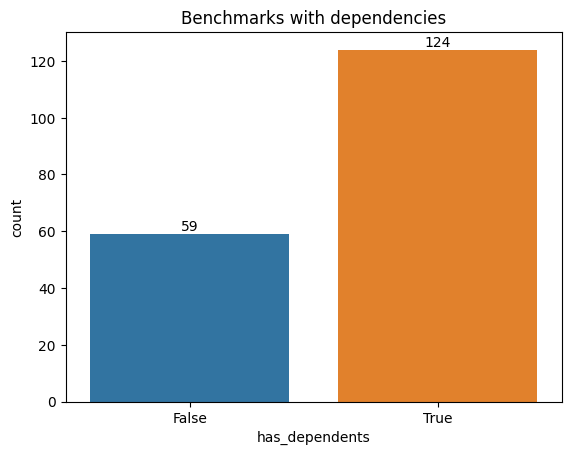

In [16]:
by_automaton_df["has_dependents"] = by_automaton_df["total_dependents"] > 0
ax = sns.countplot(data=by_automaton_df, x='has_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Benchmarks with dependencies");

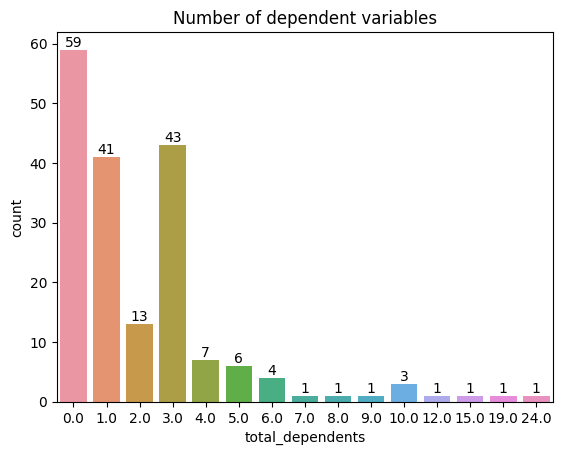

In [17]:
ax = sns.countplot(data=by_automaton_df, x='total_dependents')
ax.bar_label(ax.containers[0]);
ax.set_title("Number of dependent variables");

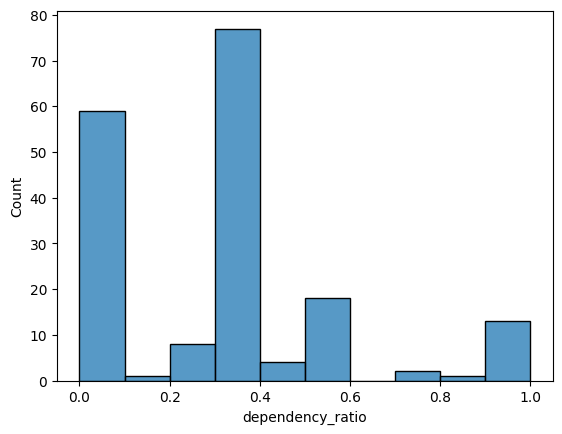

In [21]:
sns.histplot(data=by_automaton_df, x='dependency_ratio', bins=10);